In [1]:
"""
Notebook: 02_customer_churn_prediction_model.ipynb  
Purpose: Train and evaluate machine learning models to predict customer churn.

Workflow:
1. Split preprocessed data into train/test sets  
2. Build pipelines for Random Forest, Logistic Regression, Gradient Boosting, and XGBoost  
3. Address class imbalance using SMOTE  
4. Perform hyperparameter tuning with GridSearchCV  
5. Evaluate models using classification metrics (Precision, Recall, F1-score, ROC AUC)
"""

# --- Imports ---

# Standard libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For enhanced visualizations

# Machine learning models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Model selection & evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, accuracy_score,
    precision_score, recall_score, f1_score, precision_recall_curve
)

# Preprocessing & pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Adjust system path for custom preprocessing
sys.path.append(os.path.abspath(".."))
from src.preprocess import build_preprocessor, num_features, cat_features

In [2]:
# Load from CSV
X = pd.read_csv('../data/X.csv')
y = pd.read_csv('../data/y.csv')

# Prediction Models

In [3]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, "Test set shape:", X_test.shape)

Training set shape: (5625, 19) Test set shape: (1407, 19)


In [4]:
X_train = X_train.reset_index(drop=True)  # Keep as DataFrame, remove index
y_train = y_train.values.ravel()  # Convert y_train to NumPy array

X_test = X_test.reset_index(drop=True)  # Keep as DataFrame, remove index
y_test = y_test.values.ravel()  # Convert y_test to NumPy array


## Random Forest

In [5]:
# pipeline that preprocesses data, smote for class imbalance, and random forest

# using imported function
preprocessor = build_preprocessor()

rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

In [6]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    rf_pipeline, param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
y_pred_rf = grid_search.predict(X_test)
y_proba_rf = grid_search.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      1033
           1       0.54      0.70      0.61       374

    accuracy                           0.76      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.76      0.77      1407

ROC AUC Score: 0.8262497994005312


## Logistic Regression

In [7]:
# Logistic Regression pipeline with preprocessing and SMOTE
logreg_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        solver='liblinear',  # liblinear works well for small datasets & binary classification
        random_state=42
    ))
])

# Fit the pipeline
logreg_pipeline.fit(X_train, y_train)

# Predict
y_pred_logreg = logreg_pipeline.predict(X_test)
y_proba_logreg = logreg_pipeline.predict_proba(X_test)[:, 1]

In [8]:
# Define parameter grid for Logistic Regression
param_grid_logreg = {
    'classifier__penalty': ['l2'],
    'classifier__C': [ 0.1, 1, 10],  # Regularization strength (inverse of lambda)
    'classifier__solver': ['liblinear', 'lbfgs'],  # Solver options
    'classifier__max_iter': [1000],  # Max iterations for convergence
}

# Logistic Regression pipeline with preprocessing and SMOTE
logreg_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('classifier', LogisticRegression(
        class_weight='balanced',  # Handle imbalance
        random_state=42
    ))
])

# GridSearchCV to tune hyperparameters
grid_search_logreg = GridSearchCV(
    logreg_pipeline, param_grid_logreg,
    cv=3,
    scoring='roc_auc',  # Optimize for ROC AUC
    n_jobs=-1,
    verbose=1
)

# Fit grid search to training data
grid_search_logreg.fit(X_train, y_train)

# Best parameters
print("Best parameters for Logistic Regression:", grid_search_logreg.best_params_)

# Predict with the best model
y_pred_logreg = grid_search_logreg.predict(X_test)
y_proba_logreg = grid_search_logreg.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_pred_logreg))
print("ROC AUC Score (Logistic Regression):", roc_auc_score(y_test, y_proba_logreg))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.74      0.75      1407

ROC AUC Score (Logistic Regression): 0.83163621868707


## Gradient Boosting

In [9]:
# Gradient Boosting pipeline
gb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('classifier', GradientBoostingClassifier(
        n_estimators=100,  # Number of boosting stages
        learning_rate=0.1,  # Step size for weight updates
        max_depth=3,  # Tree depth to control complexity
        subsample=0.8,  # Fraction of samples used for each boosting iteration
        random_state=42
    ))
])

# Fit the pipeline
gb_pipeline.fit(X_train, y_train)

# Predict
y_pred_gb = gb_pipeline.predict(X_test)
y_proba_gb = gb_pipeline.predict_proba(X_test)[:, 1]


In [10]:
# Define parameter grid for Gradient Boosting
param_grid_gb = {
    'classifier__n_estimators': [100, 200],  # Number of trees
    'classifier__learning_rate': [0.01, 0.1],  # Step size
    'classifier__max_depth': [3, 5],  # Maximum depth of trees
    'classifier__subsample': [0.7, 0.8, 1.0]  # Fraction of samples per boosting iteration
}

# GridSearchCV to tune hyperparameters
grid_search_gb = GridSearchCV(
    gb_pipeline, param_grid_gb,
    cv=3,
    scoring='roc_auc',  # Optimize for ROC AUC
    n_jobs=-1,
    verbose=1
)

# Fit grid search to training data
grid_search_gb.fit(X_train, y_train)

# Best parameters
print("Best parameters for Gradient Boosting:", grid_search_gb.best_params_)

# Predict with the best model
y_pred_gb = grid_search_gb.predict(X_test)
y_proba_gb = grid_search_gb.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report (Gradient Boosting):\n", classification_report(y_test, y_pred_gb))
print("ROC AUC Score (Gradient Boosting):", roc_auc_score(y_test, y_proba_gb))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}

Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1033
           1       0.56      0.66      0.61       374

    accuracy                           0.77      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.77      0.78      1407

ROC AUC Score (Gradient Boosting): 0.831601275553784


## XGBoost

In [11]:
# XGBoost pipeline
xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('classifier', XGBClassifier(
        n_estimators=200,  # Number of boosting rounds
        learning_rate=0.1,  # Step size for weight updates
        max_depth=5,  # Tree depth to control complexity
        subsample=0.8,  # Fraction of samples used per tree
        colsample_bytree=0.8,  # Fraction of features used per tree
        eval_metric='auc',  # AUC metric for optimization
        use_label_encoder=False,  # Avoid warning on label encoding
        random_state=42
    ))
])

# Fit pipeline
xgb_pipeline.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

In [12]:
# Define parameter grid for XGBoost
param_grid_xgb = {
    'classifier__n_estimators': [100,200, 300],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5],
    'classifier__subsample': [0.7, 1.0],
    'classifier__colsample_bytree': [0.7, 1.0]
}

# GridSearchCV for hyperparameter tuning
grid_search_xgb = GridSearchCV(
    xgb_pipeline, param_grid_xgb,
    cv=3,
    scoring='roc_auc',  # Optimize for ROC AUC
    n_jobs=-1,
    verbose=1
)

# Fit grid search to training data
grid_search_xgb.fit(X_train, y_train)

# Best parameters
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

# Predict with the best model
y_pred_xgb = grid_search_xgb.predict(X_test)
y_proba_xgb = grid_search_xgb.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))
print("ROC AUC Score (XGBoost):", roc_auc_score(y_test, y_proba_xgb))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters for XGBoost: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.7}

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1033
           1       0.55      0.68      0.61       374

    accuracy                           0.77      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.77      0.77      1407

ROC AUC Score (XGBoost): 0.8317759912202143


# Results

## Model Performance

In [13]:
# Create a summary dictionary with key metrics
model_results = {
    "Model": ["Random Forest", "Logistic Regression", "Gradient Boosting", "XGBoost"],
    "ROC AUC": [roc_auc_score(y_test, y_proba_rf), roc_auc_score(y_test, y_proba_logreg),
                roc_auc_score(y_test, y_proba_gb), roc_auc_score(y_test, y_proba_xgb)],
    "Accuracy": [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_logreg),
                 accuracy_score(y_test, y_pred_gb), accuracy_score(y_test, y_pred_xgb)],
    "Precision": [precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_logreg),
                  precision_score(y_test, y_pred_gb), precision_score(y_test, y_pred_xgb)],
    "Recall": [recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_logreg),
               recall_score(y_test, y_pred_gb), recall_score(y_test, y_pred_xgb)],
    "F1 Score": [f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_logreg),
                 f1_score(y_test, y_pred_gb), f1_score(y_test, y_pred_xgb)]
}

# Convert dictionary to DataFrame
summary_df = pd.DataFrame(model_results)

# Display table
summary_df

,Model,ROC AUC,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.826250,0.764037,0.543750,0.697861,0.611241
1,Logistic Regression,0.831636,0.735608,0.501695,0.791444,0.614108
2,Gradient Boosting,0.831601,0.771855,0.560364,0.657754,0.605166
3,XGBoost,0.831776,0.767591,0.551198,0.676471,0.607443


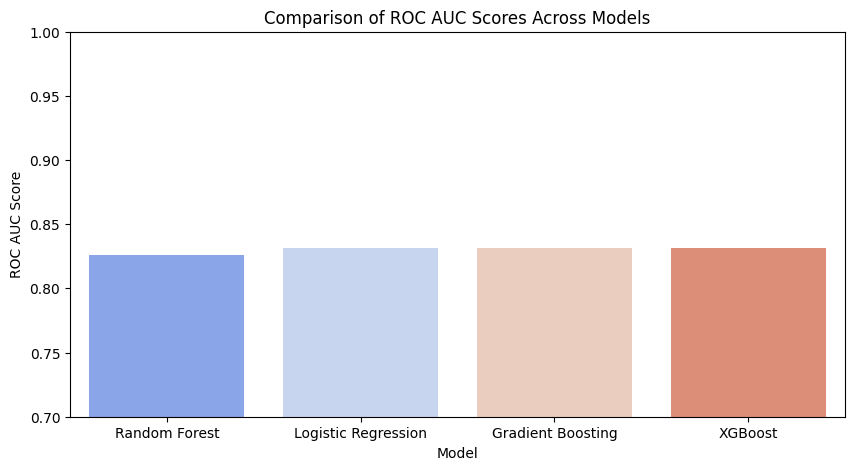

In [14]:
# Plotting ROC AUC scores across models
plt.figure(figsize=(10, 5))
sns.barplot(x=summary_df["Model"], y=summary_df["ROC AUC"], palette="coolwarm")
plt.xlabel("Model")
plt.ylabel("ROC AUC Score")
plt.title("Comparison of ROC AUC Scores Across Models")
plt.ylim(0.7, 1)  # Adjust range for better visualization

# save image
save_path = os.path.join(os.path.abspath(".."), "visuals", "roc_auc_across_models.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

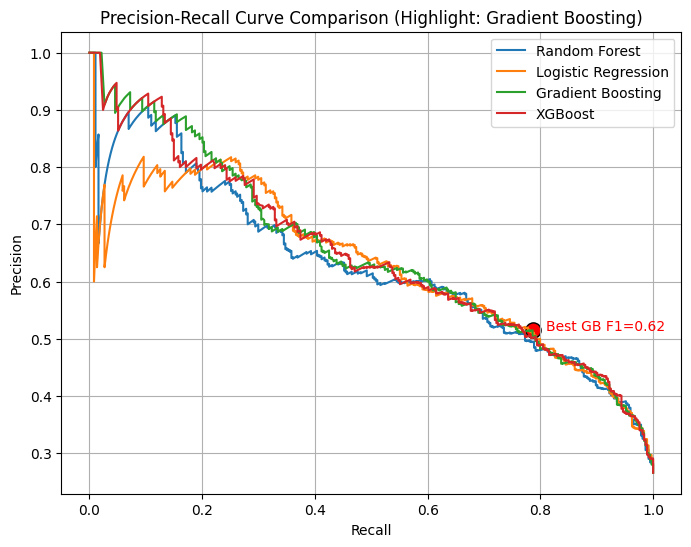

In [15]:
# Plotting precission-recall curves for each and identifying which model has highest F1
models = {
    "Random Forest": y_proba_rf,
    "Logistic Regression": y_proba_logreg,
    "Gradient Boosting": y_proba_gb,
    "XGBoost": y_proba_xgb
}

best_f1_gb = 0
best_precision_gb = 0
best_recall_gb = 0
best_curve_gb = ([], [])

plt.figure(figsize=(8, 6))

for model_name, y_proba in models.items():
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = (2 * precision * recall) / (precision + recall)  # Compute F1-score at each threshold

    # Plot Precision-Recall curve for all models
    plt.plot(recall, precision, label=model_name)

    # Track the best F1-score for Gradient Boosting
    if model_name == "Gradient Boosting":
        best_idx_gb = np.argmax(f1_scores)
        best_f1_gb = f1_scores[best_idx_gb]
        best_precision_gb, best_recall_gb = precision[best_idx_gb], recall[best_idx_gb]
        best_curve_gb = (recall, precision)

# Highlight Gradient Boosting's best F1-score point
plt.scatter(best_recall_gb, best_precision_gb, marker='o', color='red', edgecolor='black', s=120)
plt.text(best_recall_gb + 0.13, best_precision_gb, f"Best GB F1={best_f1_gb:.2f}", fontsize=10, ha='center', color='red')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison (Highlight: Gradient Boosting)")
plt.legend()
plt.grid()
# save image
save_path = os.path.join(os.path.abspath(".."), "visuals", "precision_recall_curves.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

### Model Performance Summary

| Model                | ROC AUC  | Accuracy | Precision | Recall  | F1 Score |
|----------------------|----------|----------|-----------|---------|----------|
| **Random Forest**        | 0.8263   | 0.7640   | 0.5438    | 0.6979  | 0.6112   |
| **Logistic Regression**  | 0.8316   | 0.7356   | 0.5017    | 0.7914  | 0.6141   |
| **Gradient Boosting**    | 0.8316   | 0.7719   | 0.5604    | 0.6578  | 0.6052   |
| **XGBoost**              | 0.8318   | 0.7676   | 0.5512    | 0.6765  | 0.6074   |

---

### Key Insights from Model Performance

**1. Best Overall ROC AUC**  
- XGBoost (`0.8318`) narrowly leads, followed closely by Logistic Regression (`0.8316`).  
- All models show very close ROC AUC scores ➝ feature importance is consistently informative across models.

**2. Accuracy Comparison**  
- Gradient Boosting performs best (`0.7719`), with XGBoost (`0.7676`) and Random Forest (`0.7640`) close behind.  
- Logistic Regression trails at (`0.7356`), possibly due to its recall-heavy strategy.

**3. Precision vs. Recall Trade-off**  
- Logistic Regression maximizes recall (`0.7914`) but at the expense of precision (`0.5017`).  
- Gradient Boosting gives the highest precision (`0.5604`) with decent recall (`0.6578`).  
- XGBoost strikes a solid middle ground, with good balance between recall (`0.6765`) and precision (`0.5512`).

---

### Interpretation for Churn Reduction Strategy

**If high recall is the goal (e.g., catching most churners):**  
- Logistic Regression is ideal:  
  `Recall = 0.7914`, best for broad and proactive customer retention.  
  Logistic Regression captures more potential churn cases, making it valuable for proactive customer retention efforts.  
- XGBoost is a solid alternative, maintaining better balance than Logistic Regression.

**If high precision is the goal (e.g., minimizing false positives):**  
- Gradient Boosting is best:  
  `Precision = 0.5604`, great for targeted and cost-efficient outreach.  
  These models might be better for targeted intervention strategies (e.g., offering incentives only to high-risk customers).  
- Random Forest is also reliable for this use case.

---

### Model Selection Depends on Business Strategy

| Strategy Focus        | Recommended Models                  |
|------------------------|--------------------------------------|
| **Max Recall**         | Logistic Regression, XGBoost         |
| **Max Precision**      | Gradient Boosting, Random Forest     |
| **Balanced Approach**  | XGBoost, Gradient Boosting           |


## Feature Importance

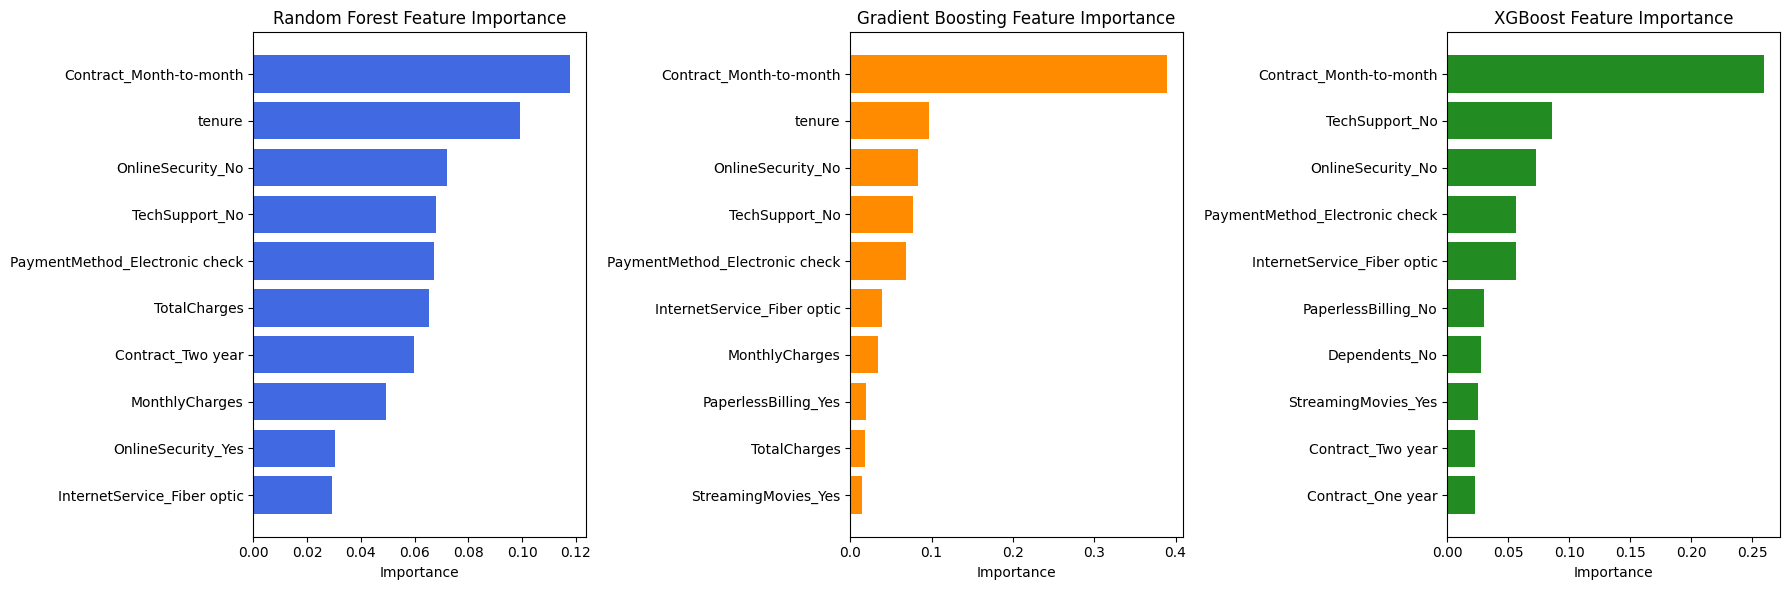

In [16]:
# Feature importance plot of RF, XGBoost, and Gradient boosting (not possible for LR)
# Ensure grid searches ran
assert 'grid_search' in globals(), "Run the Random Forest GridSearchCV cell first."
assert 'grid_search_xgb' in globals(), "Run the XGBoost GridSearchCV cell first."
assert 'grid_search_gb' in globals(), "Run the Gradient Boosting GridSearchCV cell first."

# Retrieve feature importances for each model
importances_rf = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
importances_xgb = grid_search_xgb.best_estimator_.named_steps['classifier'].feature_importances_
importances_gb = grid_search_gb.best_estimator_.named_steps['classifier'].feature_importances_

# Get feature names after preprocessing
feature_names = (
    num_features +
    grid_search.best_estimator_.named_steps['preprocessor']
        .named_transformers_['cat']
        .named_steps['onehot']
        .get_feature_names_out(cat_features).tolist()
)

# Select top 10 features for each model
sorted_idx_rf = np.argsort(importances_rf)[-10:]
sorted_idx_xgb = np.argsort(importances_xgb)[-10:]
sorted_idx_gb = np.argsort(importances_gb)[-10:]

# Create subplots for better visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Random Forest Feature Importance
axes[0].barh([feature_names[i] for i in sorted_idx_rf], importances_rf[sorted_idx_rf], color='royalblue')
axes[0].set_title("Random Forest Feature Importance")
axes[0].set_xlabel("Importance")

# Gradient Boosting Feature Importance
axes[1].barh([feature_names[i] for i in sorted_idx_gb], importances_gb[sorted_idx_gb], color='darkorange')
axes[1].set_title("Gradient Boosting Feature Importance")
axes[1].set_xlabel("Importance")

# XGBoost Feature Importance
axes[2].barh([feature_names[i] for i in sorted_idx_xgb], importances_xgb[sorted_idx_xgb], color='forestgreen')
axes[2].set_title("XGBoost Feature Importance")
axes[2].set_xlabel("Importance")

plt.tight_layout()

# save image
save_path = os.path.join(os.path.abspath(".."), "visuals", "feature_importance.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

***Feature Importance Analysis Across Models***

**Key Observations**
1. **Contract Type (Month-to-Month) is Dominant**
   - All models emphasize **month-to-month contracts** as the strongest predictor of churn.
   - Customers on **month-to-month plans** are at significantly higher risk compared to long-term contract holders.


2. **Tenure & Support Services Play a Crucial Role**
   - **Short tenure increases churn risk**, while longer-tenure customers are more stable.
   - **Tech Support & Online Security absence** contribute significantly to churn, especially in **XGBoost & Gradient Boosting**.


3. **Payment Method Matters**
   - **Electronic check payments** are consistently flagged across models, indicating higher churn risk.
   - This suggests potential underlying behavioral or financial patterns among customers using electronic checks.

**Differences Across Models**
- **Gradient Boosting:** Strongly focuses on **Contract Type (Month-to-Month)** (~0.38 importance), meaning it relies heavily on this feature.
- **XGBoost:** Distributes importance across features more evenly but emphasizes **Tech Support & Online Security**.
- **Random Forest:** More balanced, spreading importance among **tenure, contract type, and payment method**.

**Why Do Models Show Large Differences?**
1. **Different Learning Mechanisms**
   - **Random Forest** averages multiple decision trees, leading to more distributed feature importance.
   - **Gradient Boosting** builds trees sequentially, focusing on correcting previous errors—resulting in a few dominant features.
   - **XGBoost** applies regularization, preventing over-reliance on one feature and leading to more balanced importance.


2. **Feature Splitting Behavior**
   - Models determine importance based on how often a feature contributes to splits.
   - If a feature (e.g., "Month-to-Month Contract") is optimal early in tree splits, it gets high importance.
   - Gradient Boosting may focus heavily on one **key feature**, making others seem less relevant.


**Next Steps Based on Findings**
* **Target Month-to-Month Customers** with retention strategies (discounted long-term contracts).  
* **Enhance Support Services**—offering security & tech support could increase stickiness.  
* **Investigate Payment Methods**—why do electronic check users churn more? Possible billing issues? 